In [664]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

salariesDC = pd.read_csv("ds_salaries.csv")
np.random.seed(0)

In [665]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
return false;
}

<IPython.core.display.Javascript object>

### Data Sience Salaries ###

As we see above, I've already added the dataset. 

Hi, I'm very interested in being a data sience engineer. But before i want to take this path i really want to know how much this job gets payed. That is why I'm working with this dataset. Now i can practice my skills and find out how much I might earn. :)

### Cleaning ###

I start by cleaning the dataset by making smaller categories for a few columns. I was given the job titles function and had the task to do the same with the countries to categorize them by continent.

In [666]:
def segment_job_title(job_title):
    data_scientist_titles = ['Principal Data Scientist', 'Data Scientist','Applied Scientist', 'Research Scientist', 'Applied Data Scientist', 'Lead Data Scientist', 'Staff Data Scientist', 'Principal Data Analyst','Principal Data Engineer']
    machine_learning_titles = ['ML Engineer', 'Machine Learning Engineer','Applied Machine Learning Engineer', 'Machine Learning Researcher','Machine Learning Scientist', 'Autonomous Vehicle Technician', 'AppliedMachine Learning Scientist', 'Principal Machine Learning Engineer','Machine Learning Developer', 'Lead Machine Learning Engineer', 'Machine Learning Manager']
    data_analyst_titles = ['Data Analyst', 'Data Quality Analyst','Compliance Data Analyst', 'Business Data Analyst', 'Staff Data Analyst','Lead Data Analyst', 'BI Data Analyst', 'Marketing Data Analyst', 'Finance Data Analyst']
    data_engineer_titles = ['Data Modeler', 'Data Engineer', 'ETL Engineer', 'Data DevOps Engineer', 'Big Data Engineer', 'Data Infrastructure Engineer', 'Software Data Engineer', 'Cloud Database Engineer', 'Cloud Data Engineer', 'Cloud Data Architect', 'Lead Data Engineer', 'Principal Data Engineer']
    bi_analytics_titles = ['Data Analytics Manager', 'Business Intelligence Engineer', 'Analytics Engineer', 'BI Data Engineer','Director of Data Science', 'BI Developer', 'Insight Analyst', 'Data Analytics Specialist', 'Data Analytics Lead', 'Power BI Developer', 'Cloud Data Architect']
    other_titles = ['Data Strategist', 'Computer Vision Engineer', 'AI Developer', 'Head of Data']
    if job_title in data_scientist_titles:
        return 'Data Scientist'
    elif job_title in machine_learning_titles:
        return 'Machine Learning Engineer'
    elif job_title in data_analyst_titles:
        return 'Data Analyst'
    elif job_title in data_engineer_titles:
        return 'Data Engineer'
    elif job_title in bi_analytics_titles:
        return 'Business Intelligence and Analytics'
    elif job_title in other_titles:
        return 'Other'
    else:
        return 'Uncategorized'


In [667]:
location = salariesDC['company_location'].unique()

location.sort()
location

array(['AE', 'AL', 'AM', 'AR', 'AS', 'AT', 'AU', 'BA', 'BE', 'BO', 'BR',
       'BS', 'CA', 'CF', 'CH', 'CL', 'CN', 'CO', 'CR', 'CZ', 'DE', 'DK',
       'DZ', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GH', 'GR', 'HK', 'HN',
       'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IR', 'IT', 'JP', 'KE',
       'LT', 'LU', 'LV', 'MA', 'MD', 'MK', 'MT', 'MX', 'MY', 'NG', 'NL',
       'NZ', 'PH', 'PK', 'PL', 'PR', 'PT', 'RO', 'RU', 'SE', 'SG', 'SI',
       'SK', 'TH', 'TR', 'UA', 'US', 'VN'], dtype=object)

### First challenge: changing the country codes ###

As we can see in the output above there are alot of country codes. To make these into smaller categories I asked ChatGPT to organise these country codes into continents and then used the same function as above to categorize them into continents.

In [668]:

def get_continents(company_location):
    Asia = ['AE', 'AM', 'CN', 'HK', 'ID', 'IL', 'IN', 'IQ', 'IR', 'JP', 'MY', 'PH', 'PK', 'SG']
    Africa = ['DZ', 'GH', 'KE', 'MA', 'NG']
    NorthAmerica = ['BS', 'CA', 'CR', 'MX', 'PR', 'US']
    SouthAmerica = ['AR', 'BO', 'BR', 'CL']
    Europe = ['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MD', 'MK', 'MT', 'NL', 'PL', 'PT', 'RO', 'RU', 'SE', 'SI', 'SK', 'UA']
    Oceania = ['AU', 'NZ']
    if company_location in Asia:
        return 'Asia'
    if company_location in Oceania:
        return 'Oceania'
    elif company_location in NorthAmerica:
        return 'NorthAmerica'
    elif company_location in Africa:
        return 'Africa'
    elif company_location in SouthAmerica:
        return 'SouthAmerica'
    elif company_location in Europe:
        return 'Europe'
    else:
        return 'Uncategorized'
    

Now we have a few continents to work with. Let's check if this worked.

In [669]:
print(get_continents('US'))  
print(get_continents('GB'))

NorthAmerica
Europe


Yep that looks good. Just in case we'll also check if there are any missing values that need to be cleaned.

In [670]:
salariesDC.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

As we can see the dataset is clean and there is no further work to do on this part.

Let's look at a small visualisation of what were working with:

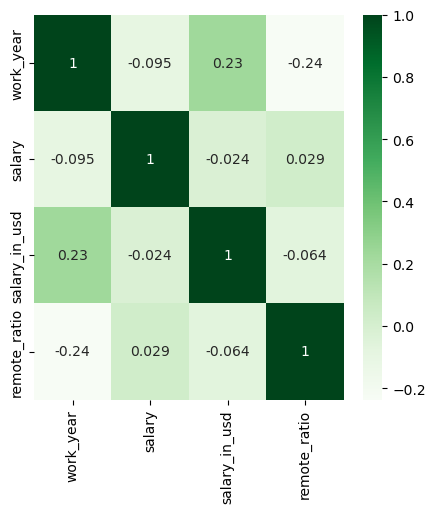

In [671]:
plt.figure(figsize=(5,5))
sns.heatmap(salariesDC.corr(),annot=True,cmap='Greens')
plt.show()

## time to do the grid search with cross validation ##

First we split our dataset into training and testing.

In [672]:
X = salariesDC.drop('salary', axis=1)  # Assuming 'salary' is the target variable
y = salariesDC['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train  # Print the training features

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
2238,2022,SE,FT,Data Engineer,EUR,36773,ES,0,ES,M
485,2023,MI,FT,Research Scientist,USD,151800,US,100,US,M
2177,2022,SE,FT,Data Analyst,USD,100000,US,0,US,M
3305,2022,SE,FT,Data Engineer,USD,156600,US,100,US,M
1769,2023,SE,FT,Data Engineer,USD,175000,US,100,US,M
...,...,...,...,...,...,...,...,...,...,...
1130,2023,SE,FT,Machine Learning Engineer,USD,150000,US,100,US,M
1294,2023,SE,FT,Data Analyst,USD,180180,US,0,US,M
860,2023,EX,FT,Data Engineer,USD,310000,US,100,US,M
3507,2021,MI,FT,Research Scientist,EUR,62649,FR,50,FR,M


Then we start to do the grid search. This is where i ran into a problem. The grid search gave me an error about the object types so we needed to change those to int64.

In [673]:
#grid_search.fit(X_train, y_train) 

# gives me an error that it cant convert type string to float

print(salariesDC.dtypes)

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object


the grid search expects a numerical input so this is why we are using OneHotEncoder that created binary columns so we can use these in the grid search.

In [674]:
categorical_columns = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']
onehot_encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = pd.DataFrame(onehot_encoder.fit_transform(X[categorical_columns]))
X_encoded.columns = onehot_encoder.get_feature_names(categorical_columns)
X_encoded = pd.concat([X_encoded, X.select_dtypes(include=['float64'])], axis=1)

/Users/alex/opt/anaconda3/envs/DataAnalytics/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Let's check if what we did is correct.

In [675]:
print(salariesDC.dtypes)

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object


In [676]:
print(salariesDC['employee_residence'].unique())

['ES' 'US' 'CA' 'DE' 'GB' 'NG' 'IN' 'HK' 'PT' 'NL' 'CH' 'CF' 'FR' 'AU'
 'FI' 'UA' 'IE' 'IL' 'GH' 'AT' 'CO' 'SG' 'SE' 'SI' 'MX' 'UZ' 'BR' 'TH'
 'HR' 'PL' 'KW' 'VN' 'CY' 'AR' 'AM' 'BA' 'KE' 'GR' 'MK' 'LV' 'RO' 'PK'
 'IT' 'MA' 'LT' 'BE' 'AS' 'IR' 'HU' 'SK' 'CN' 'CZ' 'CR' 'TR' 'CL' 'PR'
 'DK' 'BO' 'PH' 'DO' 'EG' 'ID' 'AE' 'MY' 'JP' 'EE' 'HN' 'TN' 'RU' 'DZ'
 'IQ' 'BG' 'JE' 'RS' 'NZ' 'MD' 'LU' 'MT']


For the grid search we need to use "Param_grid" which i was very confused about but after some research i found out that it cross validates the variables to find the 
best one and uses those parameters to do the grid search.

Now we do the grid search again and lets see what the outcomes are.

In [677]:
dtc = DecisionTreeClassifier()

param_grid =   {    
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    }  


In [678]:
grid_search = GridSearchCV(dtc, param_grid, cv=5)


In [679]:
grid_search.fit(X_encoded, y)

/Users/alex/opt/anaconda3/envs/DataAnalytics/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5, 10]})

In [680]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params

{'max_depth': None, 'min_samples_split': 10}

In [681]:
best_score

0.0559254327563249

So, as we can see our best_score is very low. When trying to fix this problem I widened the 

In [682]:
dtc = DecisionTreeClassifier()

param_grid =   {    
        'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20, 25, 30, 40, 50],
    'min_samples_split': [2, 5, 10 ,20,25, 30, 40, 50],
    'min_samples_leaf': [1, 2, 3, 4 , 5 , 10, 20, 40],
    }   
grid_search = GridSearchCV(dtc, param_grid, cv=5)

In [683]:
#grid_search.fit(X_encoded, y)

In [684]:
##best_params = grid_search.best_params_
#best_score = grid_search.best_score_

#best_params

In [685]:
best_score

0.0559254327563249

### Feature Importance ###

feature importance is needed to show the most relevant features that are needed for the decision-making process. 
So the output will show a score of importance.

In [686]:
dtc.fit(X_encoded, y)

importance = dtc.feature_importances_

for feature_name, feature_importance in zip(X.columns, importance):
    print(f"{feature_name}: {feature_importance}")

work_year: 0.014206488805654838
experience_level: 0.043204669507350066
employment_type: 0.038945345080763104
job_title: 0.0030535061244528427
salary_currency: 0.008407148077020222
salary_in_usd: 0.008318829897629129
employee_residence: 0.007101479707460753
remote_ratio: 0.0
company_location: 0.009135591030578044
company_size: 0.008389794493754916


From high to low these are the top 6 most relevant features.

experience_level
employment_type
work_year
comp_location
sal_cur
comp_size
